#circro_py

Circular network representations using ipython notebook.

*Cro* in Circro comes from a reference to other companion or inspiring software such as: 
* MRIcro (the original): <http://www.mccauslandcenter.sc.edu/mricro/>
* MRIcroS: <http://www.nitrc.org/projects/mricros/>

A matlab version of circro can be found here:
https://github.com/bonilhamusclab/circro

###Purpose

Sometimes, it is helpful to display complex networks as circular plots, where network nodes can be represented as arc elements in the circle, and the network edges can be demonstrated as lines connecting erc elements. 

This approach permits the visual assessment of properties of the nodes in the networks (defined by size and color of the arc elements), as well as edges. 

###Usage

This notebook "stands alone", that is, all the code necessary to generate and modify circular diagrams is embedded in this file (under **source code** below) - with the exception of a module that is downloaded to facilate testing.

The source code can be modified if needed, but it is possible to skip to **generate sample data** below to use your own data. Just make sure to execute (shift + return) all cells first to run the source code.  

##Source Code

In [1]:
%matplotlib inline

* We will load the files into the Notebook cell below
* How circro_py is implemented and may be modified can be understood via the code show in the 2 cells underneath, and descriptions & examples in the comments
* How to use circro follows below the 2 cells

###First dowload module with functions to facilitate testing
_Windows users may have to manually download file linked below if the program "curl" is not available_

In [2]:
!curl -Ok "https://raw.githubusercontent.com/bonilhamusclab-development/circro_py/master/test_utils.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1962  100  1962    0     0   2435      0 --:--:-- --:--:-- --:--:--  2434


###Next run the actual implementation

In [3]:
# %load ../circro.py
from __future__ import division

import os

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate


class InputError(Exception):
    def __init__(self, msg):
        self.msg = msg

    def __str__(self):
        return repr(self.msg)


def _inputs_to_dict(**kwords):
    """
    Return a dictionary from named arguments

    Examples
    --------
    >>> _inputs_to_dict(k1=str("v1"), k2=str("v2"))
    {'k2': 'v2', 'k1': 'v1'}
    """
    return kwords


def _lower_mask(mat, selectors=None):
    """
    >>> x = np.reshape(np.arange(9), (3, 3))
    >>> _lower_mask(x)
    array([[False, False, False],
           [ True, False, False],
           [ True,  True, False]], dtype=bool)
    >>> _lower_mask(x, x != 3)
    array([[False, False, False],
           [False, False, False],
           [ True,  True, False]], dtype=bool)
    """
    mask = np.tril(np.ones(mat.shape, dtype=bool), -1)
    if selectors is not None:
        mask = np.logical_and(mask, selectors)
    return mask


def _amin(mat, mask=None):
    """
    >>> import numpy as np
    >>> x = np.array([[1, 2], [5, -3]])
    >>> _amin(x)
    -3
    >>> _amin(x, x > 0)
    1
    """
    if mask is None:
        mask = np.ones(mat.shape, dtype=bool)
    return np.amin(mat[mask])


def _amax(mat, mask=None):
    """
    >>> import numpy as np
    >>> x = np.array([[1, 2], [5, -3]])
    >>> _amax(x)
    5
    >>> _amax(x, x < 2)
    1
    """
    if mask is None:
        mask = np.ones(mat.shape, dtype=bool)
    return np.amax(mat[mask])


def _scale_matrix(mat, new_min=0, new_max=1, selectors=None):
    """
    Return a scaled version of a matrix

    Examples
    --------
    >>> import numpy as np
    >>> x = np.array([[1, 2], [3, 5]])
    >>> _scale_matrix(x)
    array([[ 0.  ,  0.25],
           [ 0.5 ,  1.  ]])
    >>> _scale_matrix(x, 2, 4)
    array([[ 2. ,  2.5],
           [ 3. ,  4. ]])
    >>> x = np.array([[0, 1], [3, 5]])
    >>> _scale_matrix(x, 4, 8, x!=0)
    array([[ 0.,  4.],
           [ 6.,  8.]])
    >>> x = np.array([
    ...    [0, 0, 0, 0],
    ...    [1, 0, 0, 0],
    ...    [1, 1, 0, 0],
    ...    [2, 2, 3, 0]])
    >>> mask = _lower_mask(x, x < 3)
    >>> _scale_matrix(x, 4, 8, mask)
    array([[ 0.,  0.,  0.,  0.],
           [ 4.,  0.,  0.,  0.],
           [ 4.,  4.,  0.,  0.],
           [ 8.,  8.,  3.,  0.]])
    """
    if selectors is None:
        selectors = np.ones(mat.shape) == 1
    elif not np.any(selectors):
        return mat

    mx = mat[selectors].max()
    mn = mat[selectors].min()
    rg = mx - mn
    new_rg = new_max - new_min
    ratio = new_rg/rg
    new_mat = mat.copy().astype(float)
    new_mat[selectors] = (mat[selectors] - mn) * ratio + new_min
    return new_mat


def _lazy_df(fn, df):
    """
    maps each element of a Pandas dataframe into a function
    this allows for executing code in a lazy manner - only when necessary
    it also facilitates changing the dimension of each element in the dataframe
    
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> df = pd.DataFrame(np.array([[1, 2], [3, 5]]))
    >>> fn = lambda i: [i - 1, i, i + 1]
    >>> lz_df = _lazy_df(fn, df)
    >>> lz_df.iloc[0][0]()
    [0, 1, 2]
    >>> lz_df.iloc[0][1]()
    [1, 2, 3]
    >>> lz_df.iloc[1][0]()
    [2, 3, 4]
    >>> lz_df.iloc[1][1]()
    [4, 5, 6]
    """
    lazy_gen = lambda i: lambda: fn(i)
    return df.applymap(lazy_gen)


def _prep_node_data(node_data):
    """
    Reads a 2-Column CSV File with Headers into circro format
    Or
    Preps a 2-Column Data-frame into circro format
    Left column for left nodes
    Right column for right nodes

    Examples
    --------
    >>> import pandas as pd
    >>> left = pd.Series(['l1', 'l2'])
    >>> right = pd.Series(['r1', 'r2'])
    >>> df = pd.concat([left, right], axis = 1)
    >>> _prep_node_data(df)
    left   0    l1
           1    l2
    right  0    r1
           1    r2
    dtype: object
    >>> import test_utils
    >>> import os
    >>> with test_utils.temp_dir(labels = df) as d:
    ...    _prep_node_data(os.path.join(d, 'labels.csv'))
    left   0    l1
           1    l2
    right  0    r1
           1    r2
    dtype: object
    """
    data = node_data \
        if isinstance(node_data, pd.core.frame.DataFrame) \
        else pd.read_csv(node_data)

    (left, right) = data.columns
    return pd.concat([data[left], data[right]], keys=['left', 'right'])


def _create_nodes_df(filename_dict):
    """
    Converts a dictionary of node_type, node_csv_file to a dataframe
    Each column of the resultant dataframe corresponds to a different
    node type

    Examples
    --------
    >>> left = pd.Series(['BA1', 'BA2', 'BA3'])
    >>> right = pd.Series(['BA4', 'BA5', 'BA6'])
    >>> labels = pd.concat([left, right], keys=['left', 'right'], axis = 1)
    >>> sizes_left = pd.Series([1., 2., 3.])
    >>> sizes_right = pd.Series([1.5, 2.5, 3.5])
    >>> sizes = pd.concat([sizes_left, sizes_right], axis = 1)
    >>> import test_utils
    >>> with test_utils.temp_dir(labels = labels, sizes = sizes) as d:
    ...    labels_f = os.path.join(d, 'labels.csv')
    ...    sizes_f = os.path.join(d, 'sizes.csv')
    ...    x = {str('labels'): labels_f, str('sizes'): sizes_f}
    ...    full_df = _create_nodes_df(x)
    ...    del x['labels']
    ...    part_df = _create_nodes_df(x)
    >>> full_df
            labels  sizes
    left  0    BA1    1.0
          1    BA2    2.0
          2    BA3    3.0
    right 0    BA4    1.5
          1    BA5    2.5
          2    BA6    3.5
    >>> part_df
             sizes
    left  0    1.0
          1    2.0
          2    3.0
    right 0    1.5
          1    2.5
          2    3.5
    """
    node_file_keys = ['labels', 'sizes', 'colors']
    series_dict = {k: f if isinstance(f, pd.core.frame.DataFrame) else _prep_node_data(f)
                   for k, f in filename_dict.items()
                   if f is not None and k in node_file_keys}
    return pd.concat(series_dict.values(), axis=1, keys=series_dict.keys())


def _create_edges_df(edge_file, left_len, right_len):
    """
    Reads a CSV file with a header row & data with dimensions
    number of nodes by number of nodes

    Which rows/cols are specified as right or left set by inputs
    left_len and right_len

    Examples
    --------
    >>> import pandas as pd
    >>> edges = pd.DataFrame([
    ...     [0.0, 1.2, 1.3, 1.4, 1.5, 1.6],
    ...     [1.2, 0.0, 2.3, 0.0, 0.0, 0.0],
    ...     [1.3, 2.3, 0.0, 0.0, 0.0, 3.6],
    ...     [1.4, 0.0, 0.0, 0.0, 4.5, 0.0],
    ...     [1.5, 0.0, 0.0, 4.5, 0.0, 0.0],
    ...     [1.6, 0.0, 3.6, 0.0, 0.0, 0.0]])
    >>> from test_utils import temp_dir
    >>> import os
    >>> with temp_dir(edge_matrix = edges) as d:
    ...     f = os.path.join(d, 'edge_matrix.csv')
    ...     _create_edges_df(f, 3, 3)
            left           right          
               0    1    2     0    1    2
    left  0  0.0  1.2  1.3   1.4  1.5  1.6
          1  1.2  0.0  2.3   0.0  0.0  0.0
          2  1.3  2.3  0.0   0.0  0.0  3.6
    right 0  1.4  0.0  0.0   0.0  4.5  0.0
          1  1.5  0.0  0.0   4.5  0.0  0.0
          2  1.6  0.0  3.6   0.0  0.0  0.0
    """
    outer_index = ['left']*left_len + ['right']*right_len
    inner_index = range(left_len) + range(right_len)
    index = pd.MultiIndex.from_arrays([outer_index, inner_index])

    edges = pd.read_csv(edge_file, header=None)
    edges.columns = index
    edges.index = index
    return edges


def _raise_input_error(inputs):
    raise InputError("at least one of {} inputs must be set".format(inputs))


def make_circro(labels=None, sizes=None, colors=None, edge_matrix=None,
                inner_r=1.0, start_radian=np.pi/2, edge_threshold=.5, node_cm='jet', edge_cm='jet',
                draw_labels=True, draw_nodes_colorbar=None, edge_render_thickness=None):
    """
    Generates a circular diagram data structure that contains data to be rendered with
    plot_circro. See plot_circro

    Examples
    --------
    >>> from test_utils import temp_dir
    >>> import pandas as pd
    >>> left = pd.Series([1, 2, 3])
    >>> right = pd.Series([1.5, 2.5, 3.5])
    >>> sizes = pd.concat([left, right], axis=1)
    >>> import os
    >>> with temp_dir(sizes = sizes) as d:
    ...    my_circ = make_circro(sizes = os.path.join(d, 'sizes.csv'))
    >>> sorted(my_circ.keys())
    ['draw_labels', 'draw_nodes_colorbar', 'edge_cm', 'edge_render_thickness', 'edge_threshold', 'inner_r', 'node_cm', 'nodes', 'start_radian']
    >>> my_circ['nodes']
             sizes
    left  0    1.0
          1    2.0
          2    3.0
    right 0    1.5
          1    2.5
          2    3.5
    """
    inputs = _inputs_to_dict(labels=labels, sizes=sizes,
                             colors=colors, edge_matrix=edge_matrix)

    file_keys = ['labels', 'sizes', 'colors', 'edge_matrix']

    if all([inputs[f] is None for f in file_keys]):
        _raise_input_error(file_keys)

    res = dict()
    res['nodes'] = _create_nodes_df(inputs) 
    if edge_matrix:
        res['edges'] = _create_edges_df(edge_matrix,
                                        len(res['nodes'].loc['left']),
                                        len(res['nodes'].loc['right']))

    res['inner_r'] = inner_r
    res['start_radian'] = start_radian
    res['edge_threshold'] = edge_threshold

    res['node_cm'] = node_cm
    res['edge_cm'] = edge_cm

    res['draw_labels'] = draw_labels
    res['draw_nodes_colorbar'] = draw_nodes_colorbar \
        if draw_nodes_colorbar is not None else 'colors' in res['nodes']

    res['edge_render_thickness'] = edge_render_thickness

    return res


def make_circro_from_dir(src_dir, inner_r=1.0, start_radian=np.pi/2, edge_threshold=.5,
                         node_cm='jet', edge_cm='jet', draw_labels=True,
                         draw_nodes_colorbar=True, edge_render_thickness=None):
    """
    Wrapper for make_circro
    src_dir must contain at least one of the following files:
        labels.csv, colors.csv, sizes.csv, edge_matrix.csv

    Examples
    --------
    >>> import pandas as pd
    >>> edges_df = pd.DataFrame([
    ...     [0.0, 1.2, 1.3, 1.4, 1.5, 1.6],
    ...     [1.2, 0.0, 2.3, 0.0, 0.0, 0.0],
    ...     [1.3, 2.3, 0.0, 0.0, 0.0, 3.6],
    ...     [1.4, 0.0, 0.0, 0.0, 4.5, 0.0],
    ...     [1.5, 0.0, 0.0, 4.5, 0.0, 0.0],
    ...     [1.6, 0.0, 3.6, 0.0, 0.0, 0.0]])
    >>> sizes_left = pd.Series([i for i in range(3)])
    >>> sizes_right = pd.Series([i + .5 for i in range(3)])
    >>> sizes_df = pd.concat([sizes_left, sizes_right], axis = 1)
    >>> labels_left = pd.Series(['L' + l for l in 'ABC'])
    >>> labels_right = pd.Series(['R' + l for l in 'ABC'])
    >>> labels_df = pd.concat([labels_left, labels_right], axis = 1)
    >>> colors_df = sizes_df
    >>> from test_utils import temp_dir
    >>> with temp_dir(sizes = sizes_df, labels = labels_df, colors = colors_df, edge_matrix = edges_df) as d:
    ...     full_path = lambda(s): os.path.join(d, s)
    ...     sizes = full_path('sizes.csv')
    ...     labels = full_path('labels.csv')
    ...     colors = full_path('colors.csv')
    ...     edges = full_path('edge_matrix.csv')
    ...     my_circ_dir = make_circro_from_dir(d)
    ...     my_circ = make_circro(labels = labels,
    ...         sizes = sizes, colors = colors,
    ...         edge_matrix = edges)
    >>> from pandas.util.testing import assert_frame_equal
    >>> from pandas.util.testing import assert_series_equal
    >>> assert_col = lambda col: assert_frame_equal(my_circ[col], my_circ_dir[col])
    >>> assert_nodes_col = lambda col: assert_series_equal(my_circ['nodes'][col], my_circ_dir['nodes'][col])
    >>> assert_col('nodes')
    >>> assert_nodes_col('sizes')
    >>> assert_nodes_col('colors')
    >>> assert_col('edges')
    """
    file_keys = {'labels', 'colors', 'sizes', 'edge_matrix'}

    def add_file_input(acc, i):
        f = os.path.join(src_dir, i + '.csv')
        acc[i] = f if os.path.isfile(f) else None
        return acc
    
    inputs = reduce(add_file_input, file_keys, dict())

    if all([inputs[i] is None for i in file_keys]):
        _raise_input_error(file_keys)

    inputs.update(_inputs_to_dict(inner_r=inner_r, start_radian=start_radian,
                                  edge_threshold=edge_threshold, node_cm=node_cm, edge_cm=edge_cm,
                                  draw_labels=draw_labels, draw_nodes_colorbar=draw_nodes_colorbar,
                                  edge_render_thickness=edge_render_thickness
                                  ))

    return make_circro(**inputs)


def _calculate_radial_arc(start_radian, end_radian, radius): 
    """
    Calculates the radii and thetas corresponding to an arc between start_radian and end_radian

    Examples
    --------
    >>> import numpy as np
    >>> (rs, ts) = _calculate_radial_arc(0, np.pi, 1)
    >>> assert rs.max() == 1
    >>> assert rs.min() >= 0
    >>> assert np.logical_or(ts == 0, ts == np.pi).all()
    >>> (rs, ts) = _calculate_radial_arc(0, np.pi, 2)
    >>> assert rs.max() == 2
    >>> (rs, ts) = _calculate_radial_arc(np.pi * .5, np.pi * 1.5, 1)
    >>> assert ts.min() == np.pi * .5
    >>> assert ts.max() == np.pi * 1.5
    >>> assert np.logical_or(ts[rs == 2] == np.pi * .5, ts[rs == 2] == np.pi * 1.5).all()
    """
    [start_radian, end_radian] = np.sort([start_radian, end_radian])

    theta_gap_orig = end_radian - start_radian

    theta_gap = theta_gap_orig if theta_gap_orig < np.pi else 2*np.pi - theta_gap_orig
    
    theta_mid = np.pi/2
    theta_left = theta_mid - theta_gap/2
    theta_right = theta_mid + theta_gap/2
    thetas = [theta_left, theta_mid, theta_right]

    xs = np.cos(thetas)

    h_top = np.sin(theta_left)
    dip_coeff = np.cos(theta_gap/2)
    hs = [h_top, h_top * dip_coeff, h_top]
    h_fn = interpolate.interp1d(xs, hs, kind='quadratic')

    xs = np.linspace(start=xs[0], stop=xs[2], num=20)
    hs = h_fn(xs)
    rs = np.linalg.norm([hs, xs], axis=0)
    thetas = np.arctan2(hs, xs)
    thetas = thetas - np.min(thetas)
    
    if theta_gap_orig > np.pi:
        thetas = 2*np.pi - thetas

    thetas = thetas + start_radian
    
    return rs * radius, thetas


def _plot_info(circ):
    """
    Calculates render inputs from a circro structure
    see plot_circro, make_circro

    Examples
    --------
    >>> sizes_left = pd.Series([i for i in range(3)])
    >>> sizes_right = pd.Series([i for i in range(3)])
    >>> sizes = pd.concat([sizes_left, sizes_right], axis = 1)
    >>> from test_utils import temp_dir
    >>> import os
    >>> with temp_dir(sizes = sizes) as d:
    ...    my_circ = make_circro(sizes = os.path.join(d, 'sizes.csv'))
    >>> info = _plot_info(my_circ)
    """
    num_nodes = len(circ['nodes']) if 'nodes' in circ else len(circ['edges'])
    rad_per_node = 2 * np.pi/num_nodes

    info = {}
    nodes = pd.DataFrame()

    nodes['label'] = circ['nodes']['labels'] \
        if 'labels' in circ['nodes'] else circ['nodes'].index.labels[1]
    nodes.index = circ['nodes'].index

    nodes['size'] = circ['nodes']['sizes'] if 'sizes' in circ['nodes'] else 1

    nodes['width'] = rad_per_node
    nodes.loc['right', 'width'] = rad_per_node * -1

    node_cm = getattr(cm, circ['node_cm'])

    has_colors = 'colors' in circ['nodes']
    info['node_colors'] = node_cm(circ['nodes']['colors'] if has_colors else 1.0)
    if has_colors and circ['draw_nodes_colorbar']:
        info['node_colors_norm'] = \
            mpl.colors.Normalize(vmin=circ['nodes']['colors'].min().min(),
                                 vmax=circ['nodes']['colors'].max().max())

    start_radian = circ['start_radian']
    nodes['theta'] = nodes['width'] * nodes.index.labels[1]

    nodes['label_loc'] = nodes['theta'] * 180/np.pi
    nodes.loc['right', 'label_loc'] = nodes.label_loc.right.values + 360

    deg_per_node = np.rad2deg(rad_per_node)
    nodes.loc['left', 'label_loc'] = nodes.label_loc.left.values + deg_per_node/2
    nodes.loc['right', 'label_loc'] = nodes.label_loc.right.values - deg_per_node/2

    start_deg = np.rad2deg(start_radian)
    nodes['label_loc'] = nodes['label_loc'] + start_deg
    nodes['theta'] = nodes['theta'] + start_radian

    nodes['label_loc'] = np.mod(nodes['label_loc'], 360.0)
    nodes['theta'] = np.mod(nodes['theta'], 2*np.pi)

    info['nodes'] = nodes

    if 'edges' in circ:
        edge_vals = circ['edges'].values
        mask = _lower_mask(edge_vals, edge_vals > circ['edge_threshold'])
        info['edges_mask'] = mask
        scaled_edges = _scale_matrix(edge_vals, selectors=mask)
        scaled_edges = pd.DataFrame(data=scaled_edges, index=circ['edges'].index, columns=circ['edges'].columns)
        edge_cm = getattr(cm, circ['edge_cm'])
        info['scaled_edges'] = scaled_edges
        info['edge_colors'] = _lazy_df(edge_cm, scaled_edges)
        info['edge_colors_norm'] = mpl.colors.Normalize(
            vmin=_amin(edge_vals, mask),
            vmax=_amax(edge_vals, mask)
        )

    return info


def plot_circro(my_circ, draw=True, rc_context=None):
    """
    Renders diagram associated with a circro structure

    Examples
    --------
    my_circ = circro.make_circro_from_dir('test_data')
    plot_circro(my_circ)
    """
    if rc_context is not None:
        with plt.rc_context(rc_context):
            plot_circro(my_circ, draw, None)
        return

    info = _plot_info(my_circ)
    nodes = info['nodes']

    inner_r = my_circ['inner_r']

    ax = plt.subplot(111, projection='polar')

    if my_circ['draw_labels']:
        plt.thetagrids(nodes['label_loc'], nodes['label'])

#   turn off radial lines
    plt.grid(False, axis='y', which='both')
    plt.grid(False, axis='x', which='both')
    ax.set_yticklabels([])

    ax.bar(nodes['theta'], nodes['size'], nodes['width'], bottom=inner_r, color=info['node_colors'])
    if 'node_colors_norm' in info:
        norm = info['node_colors_norm']
        ax_color, params = mpl.colorbar.make_axes(ax, location='left')
        mpl.colorbar.ColorbarBase(ax_color, norm=norm,
                                  cmap=getattr(cm, my_circ['node_cm']), **params)

    if 'edges' in my_circ:
        edges = my_circ['edges']

        index_to_theta = lambda i: np.deg2rad(nodes.loc[i]['label_loc'])

        if my_circ['edge_render_thickness']:
            new_min, new_max = my_circ['edge_render_thickness']
            mask = info['edges_mask']
            edge_thicknesses = _scale_matrix(edges.values, new_min, new_max, mask)
            edge_thicknesses = pd.DataFrame(edge_thicknesses, index=edges.index, columns=edges.columns)
        else:
            edge_thicknesses = edges

        for col_index in edges:
            col_edges = edges[col_index][col_index:]
            start_theta = index_to_theta(col_index)
            for row_index in col_edges.index[col_edges > my_circ['edge_threshold']]:
                end_theta = index_to_theta(row_index)
                if start_theta == end_theta:
                    continue
                (radii, thetas) = _calculate_radial_arc(start_theta, end_theta, inner_r)
                clr = info['edge_colors'][col_index][row_index]()
                ax.plot(thetas, radii, color=clr, ls='-', lw=edge_thicknesses[col_index][row_index])

        norm = info['edge_colors_norm']
        ax_color, params = mpl.colorbar.make_axes(ax, location='right')
        mpl.colorbar.ColorbarBase(ax_color, norm=norm,
                                  cmap=getattr(cm, my_circ['edge_cm']), **params)

    if draw:
        plt.show()


def plot_circros(my_circs, rc_context=None):
    """
    Renders diagram for a list of circros

    Examples
    --------
    my_circ = make_circro_from_dir('test_dir', draw_labels=False)
    my_circ2 = make_circro(labels='test_dir/labels.csv', inner_r = 2)
    plot_circros([my_circ, my_circ2])
    """
    if rc_context is not None:
        with plt.rc_context(rc_context):
            plot_circros(my_circs, None)
        return

    for c in my_circs:
        plot_circro(c, draw=False)
        
    plt.show()


if __name__ == "__main__":
    import doctest
    doctest.testmod()


###Create Sample Data
The files below exhibit the data structure Circro expects

Circro expects one or more of the following files:
1. labels.csv
  * format: 2 columns (for left side of circro and right side)
  * header: yes
2. colors.csv
  * format: 2 columns (for left side of circro and right side)
  * header: yes
3. sizes.csv
  * format: 2 columns (for left side of circro and right side)
  * header: yes
4. edge_matrix.csv
  * format: num_nodes by num_nodes matrix of edge weights
  * only lower triangle of matrix rendered
  * header: no

_The files will be created with [%writefile](http://ipython.org/ipython-doc/dev/interactive/magics.html#cellmagic-writefile)_

* The Files that Describe the Nodes have 2 columns
* The Left nodes start at center and rotate counter-clockwise
* The Right nodes start at center and rotate clockwise
* This will become clearer with examples

In [4]:
%%writefile labels.csv
left,right
L0,R0
L1,R1
L2,R2
L3,R3
L4,R4
L5,R5
L6,R6
L7,R7
L8,R8
L9,R9

Overwriting labels.csv


In [5]:
%%writefile sizes.csv
left,right
.4,.3
.4,.5
.2,.5
.6,.1
.7,.4
.3,.2
.4,.4
.1,.5
.4,.4
.2,.3

Overwriting sizes.csv


In [6]:
%%writefile colors.csv
0,0
.1,.1
.2,.2
.3,.3
.4,.4
.5,.5
.6,.6
.7,.7
.8,.8
.9,.9

Overwriting colors.csv


_make simple edge file_  
Has similar structure to nodes files but without headers

In [7]:
num_nodes = 20
num_left_nodes = 10
num_right_nodes = 10

In [8]:
import pandas as pd
import numpy as np

edges = np.random.random_integers(0, high = 5, size = (num_nodes, num_nodes))
#Circro only renders the upper triangle, set rest to 0 to avoid confusing users
edges = np.tril(edges, -1)
edges_df = pd.DataFrame(edges)
edge_file = 'edge_matrix.csv'
edges_df.to_csv(edge_file, header=None, index = None) #unlike other inputs, edge matrix has no header

__View Edge Data__  
_Windows users may have to manually view data if program "cat" is not installed_

In [9]:
!cat $edge_file

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,4,4,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,2,5,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,3,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,3,2,4,5,1,4,0,0,0,0,0,0,0,0,0,0,0
3,4,2,4,1,1,3,5,0,2,0,0,0,0,0,0,0,0,0,0
5,3,4,0,3,4,0,0,1,4,4,0,0,0,0,0,0,0,0,0
5,2,0,1,2,2,4,5,4,2,1,4,0,0,0,0,0,0,0,0
0,3,0,2,4,4,3,5,4,5,1,5,3,0,0,0,0,0,0,0
4,1,3,2,0,1,1,2,0,4,0,5,2,1,0,0,0,0,0,0
5,2,5,5,0,3,2,4,2,2,1,2,4,0,4,0,0,0,0,0
1,4,1,2,4,5,2,0,1,3,5,2,3,1,2,5,0,0,0,0
5,4,2,2,3,2,0,4,5,3,3,2,2,2,1,3,2,0,0,0
1,4,3,5,4,1,2,5,3,1,5,0,5,1,5,0,5,5,0,0
5,2,2,3,2,4,4,1,3,0,3,4,0,0,2,2,3,4,4,0


#Using Circro

Once the data is ready, using Circro consists of 2 steps:
1. Generate a circro data structure
2. Plot the structure from 1

The simplest way to generate a circro structure (just a dictionary with specific fields) is via the function make_circro_from_dir
  
make_circro_from_dir expects a directory as an input with one or more of the following files:
* labels: labels.csv
* edge matrix: edge_matrix.csv
* sizes: sizes.csv
* colors: colors.csv

The current directory contains these files because they were created in the previous steps.

In [10]:
my_circ = make_circro_from_dir(".", node_cm='hot', edge_cm = 'Blues')

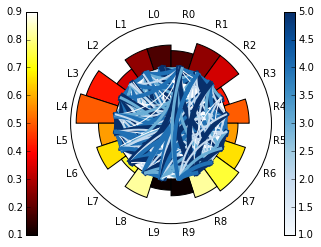

In [11]:
plot_circro(my_circ)

Too many edges, let's change the edge threshold

In [12]:
my_circ.keys()

['draw_nodes_colorbar',
 'edge_render_thickness',
 'node_cm',
 'edge_cm',
 'start_radian',
 'edges',
 'draw_labels',
 'inner_r',
 'nodes',
 'edge_threshold']

In [13]:
my_circ['edge_threshold'] = 2

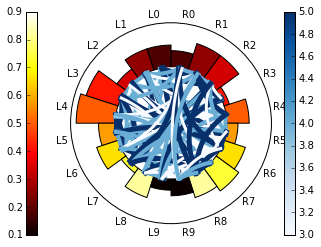

In [14]:
plot_circro(my_circ)

Edges are too thick, set render thickness

In [15]:
my_circ.keys()

['draw_nodes_colorbar',
 'edge_render_thickness',
 'node_cm',
 'edge_cm',
 'start_radian',
 'edges',
 'draw_labels',
 'inner_r',
 'nodes',
 'edge_threshold']

In [16]:
my_circ['edge_render_thickness'] = [1, 3]

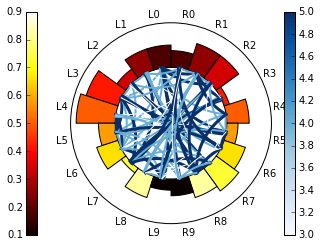

In [17]:
my_circ['edge_cm'] = 'Blues'
my_circ['node_cm=']= 'hot'

plot_circro(my_circ)

Still too many edges, a little higher threshold

In [18]:
my_circ['edge_threshold'] = 3.9
my_circ['edge_render_thickness'] = [0.1, 2]

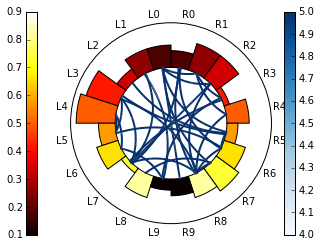

In [19]:
plot_circro(my_circ)

###Add Outer Circro Diagrams

It is sometimes beneficial to add more than 1 diagram.  
In this example, we wish to add another circro with more descriptive node labels.

In [20]:
%%writefile labels_descriptive.csv
left,right
left0,right0
left1,right1
left2,right2
left3,right3
left4,right4
left5,right5
left6,right6
left7,right7
left8,right8
left9,right9

Overwriting labels_descriptive.csv


__Can make a circro structure with a single file instead of a directory__

In [21]:
my_circ_labels = make_circro(labels= 'labels_descriptive.csv', node_cm='jet')

In [22]:
my_circ_labels['inner_r'] = 1.7

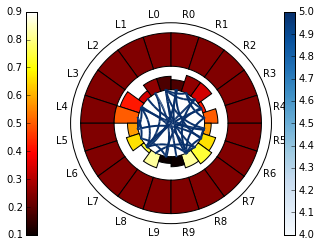

In [23]:
plot_circros([my_circ_labels, my_circ])

__The Expected Labels Are Not Being Shown__

Currently Circro only supports rendering one set of labels. A future release will provide support for rendering more than one set of labels.  

In current version, a particular diagram's labels will always be rendered if the other diagram's __"draw_labels"__ field is set to __"false"__.

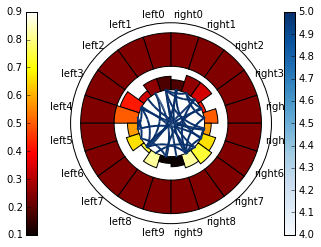

In [24]:
my_circ['draw_labels'] = False
plot_circros([my_circ_labels, my_circ])

The node sizes are too large on the outer circro

In [25]:
type(my_circ_labels['nodes'])

pandas.core.frame.DataFrame

Utizilize the advantage of broadcasting and my_circ_labels['nodes'] is a dataframe to broadcast sizes to .2

In [26]:
my_circ_labels['nodes']['sizes'] = .2

In [27]:
my_circ_labels['nodes']

labels  sizes
left  0   left0    0.2
      1   left1    0.2
      2   left2    0.2
      3   left3    0.2
      4   left4    0.2
      5   left5    0.2
      6   left6    0.2
      7   left7    0.2
      8   left8    0.2
      9   left9    0.2
right 0  right0    0.2
      1  right1    0.2
      2  right2    0.2
      3  right3    0.2
      4  right4    0.2
      5  right5    0.2
      6  right6    0.2
      7  right7    0.2
      8  right8    0.2
      9  right9    0.2

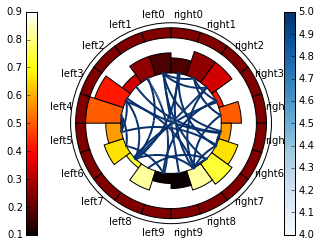

In [28]:
plot_circros([my_circ_labels, my_circ])

####Want to change color for labels circro, but forgot which 'nodes' column controls node color, will check my_circ

In [29]:
my_circ['nodes'].columns

Index([u'colors', u'labels', u'sizes'], dtype='object')

In [30]:
my_circ_labels['nodes']['colors'] = .3

In [31]:
my_circ_labels['nodes']

labels  sizes  colors
left  0   left0    0.2     0.3
      1   left1    0.2     0.3
      2   left2    0.2     0.3
      3   left3    0.2     0.3
      4   left4    0.2     0.3
      5   left5    0.2     0.3
      6   left6    0.2     0.3
      7   left7    0.2     0.3
      8   left8    0.2     0.3
      9   left9    0.2     0.3
right 0  right0    0.2     0.3
      1  right1    0.2     0.3
      2  right2    0.2     0.3
      3  right3    0.2     0.3
      4  right4    0.2     0.3
      5  right5    0.2     0.3
      6  right6    0.2     0.3
      7  right7    0.2     0.3
      8  right8    0.2     0.3
      9  right9    0.2     0.3

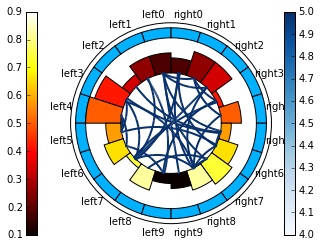

In [32]:
plot_circros([my_circ_labels, my_circ])

####The node colors may also be updated by changing the colormap

In [33]:
my_circ_labels['node_cm'] = 'bone'
my_circ_labels['nodes']['colors'] = .8

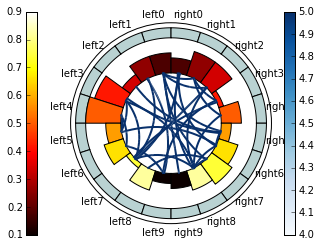

In [34]:
plot_circros([my_circ_labels, my_circ])

###rc_context support

Circro allows the passing of [rc_parameters](http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rcParams) to configure plot settings.

For example, the above graphs are small. The [figure.figsize rc option](http://matplotlib.org/users/customizing.html#a-sample-matplotlibrc-file) can be updated to enlarge figure.

In [35]:
#view current size
from pylab import rcParams
rcParams['figure.figsize']

[6.0, 4.0]

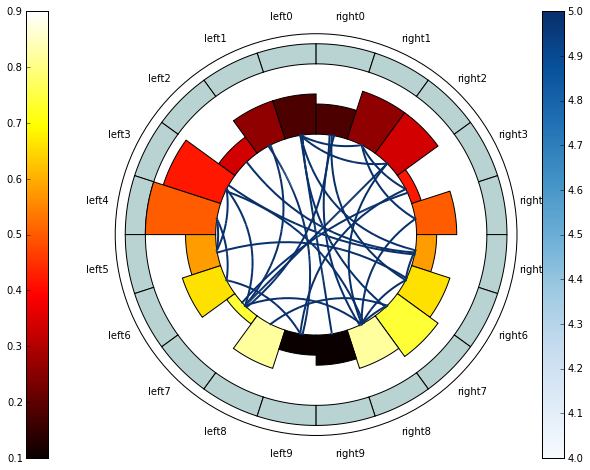

In [36]:
plot_circros([my_circ_labels, my_circ], rc_context={'figure.figsize': (12.0, 8.0)})

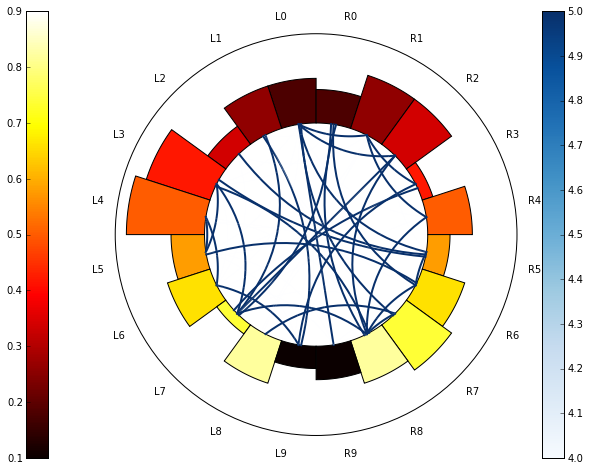

In [37]:
my_circ['draw_labels'] = True
plot_circro(my_circ, rc_context={'figure.figsize': (12.0, 8.0)})